In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os, re, nltk, joblib
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Bidirectional, Embedding, BatchNormalization
from sklearn.metrics import confusion_matrix, classification_report
import gensim

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

nltk.download('stopwords')


Using TensorFlow backend.


/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv
/kaggle/input/kernel4a06ffc86e/__results__.html
/kaggle/input/kernel4a06ffc86e/final_model.pkl
/kaggle/input/kernel4a06ffc86e/__resultx__.html
/kaggle/input/kernel4a06ffc86e/__notebook__.ipynb
/kaggle/input/kernel4a06ffc86e/word2vec.pkl
/kaggle/input/kernel4a06ffc86e/__output__.json
/kaggle/input/kernel4a06ffc86e/tokenizer.pkl
/kaggle/input/kernel4a06ffc86e/custom.css
/kaggle/input/kernel4a06ffc86e/__results___files/__results___53_1.png
/kaggle/input/kernel4a06ffc86e/__results___files/__results___52_1.png
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [4]:
df = pd.read_csv("/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv", encoding='latin-1', header=None)
df.columns = ['target','ids','date','flag','user','text']
df.target.replace({0:'Negative',2:'Neutral',4:'Positive'}, inplace=True)

stop_words = set(stopwords.words('english'))
stop_words.remove('not')

corpus = []
for text in df['text']:
    review = re.sub('@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+', ' ', text.lower())
    review = ' '.join([word for word in review.split() if word not in stop_words])
    corpus.append(review)
df['text'] = corpus


In [5]:
train_df, test_df = train_test_split(df, test_size=0.20, random_state=123)


In [6]:
documents = [text.split() for text in train_df['text']]
w2v_model = gensim.models.Word2Vec(size=300, window=7, min_count=10, workers=4)
w2v_model.build_vocab(documents)
w2v_model.train(documents, total_examples=len(documents), epochs=30)


(248012303, 279405480)

In [7]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_df['text'])
vocab_size = len(tokenizer.word_index) + 1

X_train = pad_sequences(tokenizer.texts_to_sequences(train_df['text']), maxlen=300)
X_test = pad_sequences(tokenizer.texts_to_sequences(test_df['text']), maxlen=300)

labelencoder = LabelEncoder()
y_train = labelencoder.fit_transform(train_df['target'])
y_test = labelencoder.transform(test_df['target'])


In [8]:
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]

embedding_layer = Embedding(input_dim=vocab_size,
                            output_dim=300,
                            weights=[embedding_matrix],
                            input_length=300,
                            trainable=False)


In [9]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(LSTM(64))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(3, activation='softmax'))  # multi-class output

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 300)          87187500  
_________________________________________________________________
dropout_1 (Dropout)          (None, 300, 300)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 300, 256)          439296    
_________________________________________________________________
batch_normalization_1 (Batch (None, 300, 256)          1024      
_________________________________________________________________
dropout_2 (Dropout)          (None, 300, 256)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                82176     
_________________________________________________________________
dense_1 (Dense)              (None, 64)               

In [10]:
history = model.fit(X_train, y_train,
                    batch_size=512,
                    epochs=10,
                    validation_split=0.1,
                    verbose=1)


Train on 1152000 samples, validate on 128000 samples
Epoch 1/10
1152000/1152000 [==============================] - 1424s 1ms/step - loss: 0.4783 - accuracy: 0.7702 - val_loss: 0.4434 - val_accuracy: 0.7912
Epoch 2/10
1152000/1152000 [==============================] - 1424s 1ms/step - loss: 0.4469 - accuracy: 0.7891 - val_loss: 0.4362 - val_accuracy: 0.7959
Epoch 3/10
1152000/1152000 [==============================] - 1411s 1ms/step - loss: 0.4379 - accuracy: 0.7941 - val_loss: 0.4262 - val_accuracy: 0.8016
Epoch 4/10
1152000/1152000 [==============================] - 1401s 1ms/step - loss: 0.4318 - accuracy: 0.7979 - val_loss: 0.4231 - val_accuracy: 0.8031
Epoch 5/10
1152000/1152000 [==============================] - 1403s 1ms/step - loss: 0.4279 - accuracy: 0.8003 - val_loss: 0.4242 - val_accuracy: 0.8036
Epoch 6/10
1152000/1152000 [==============================] - 1405s 1ms/step - loss: 0.4247 - accuracy: 0.8020 - val_loss: 0.4210 - val_accuracy: 0.8056
Epoch 7/10
1152000/1152000 [=

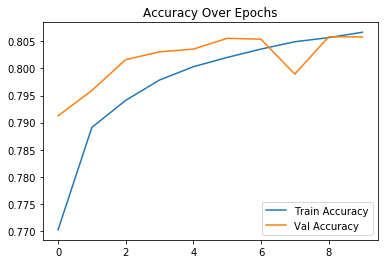

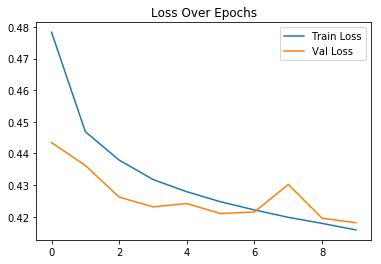

In [11]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss Over Epochs')
plt.show()


In [12]:
y_pred = model.predict(X_test).argmax(axis=1)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=labelencoder.classes_))


[[125389  34657]
 [ 27847 132107]]
              precision    recall  f1-score   support

    Negative       0.82      0.78      0.80    160046
    Positive       0.79      0.83      0.81    159954

    accuracy                           0.80    320000
   macro avg       0.81      0.80      0.80    320000
weighted avg       0.81      0.80      0.80    320000



In [13]:
def preprocess(text):
    review = re.sub('@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+', ' ', text.lower())
    review = [word for word in review.split() if word not in stop_words]
    review = pad_sequences(tokenizer.texts_to_sequences([' '.join(review)]), maxlen=300)
    return review

def predict_sentiment(text):
    processed = preprocess(text)
    pred = model.predict(processed)[0]
    label = labelencoder.classes_[np.argmax(pred)]
    print(f"Sentiment: {label}, Probabilities: {pred}")


In [14]:
joblib.dump(tokenizer, 'tokenizer.pkl')
joblib.dump(w2v_model, 'word2vec.pkl')
model.save('enhanced_lstm_model.h5')


In [15]:
model.save('/kaggle/working/final_model.h5')


In [16]:
model.save_weights('/kaggle/working/final_model_weights.h5')


In [9]:
joblib.dump(labelencoder, 'labelencoder.pkl')


['labelencoder.pkl']

In [1]:
import pkg_resources

# List only the libraries your project uses
required_libraries = [
    'numpy', 'pandas', 'matplotlib', 'scikit-learn', 'nltk',
    'gensim', 'tensorflow', 'keras', 'joblib'
]

with open('/kaggle/working/requirements.txt', 'w') as f:
    for lib in required_libraries:
        try:
            version = pkg_resources.get_distribution(lib).version
            f.write(f"{lib}=={version}\n")
        except pkg_resources.DistributionNotFound:
            print(f"Package {lib} not found, skipping...")

print("✅ requirements.txt generated at /kaggle/working/requirements.txt")


✅ requirements.txt generated at /kaggle/working/requirements.txt
